<a href="https://colab.research.google.com/github/aryamanpandya99/AIFundamentals/blob/master/MLPy/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

By Definition, an autoencoder is a neural network trained to downsize then reconstruct its input data from a latent representation. A convolutional autoencoder uses a CNN encoder to compress the input into the a latent representation and a deconvolutional (transposed convolution) decoder to reconstruct the input from the latent representation.

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib.pyplot as plt, numpy as np

In [125]:
import pandas as pd
import pathlib as Path
from torch.utils.data import DataLoader, default_collate, Dataset
from typing import Mapping

In [126]:
with open('/content/drive/MyDrive/data/cifar-10-batches-py/data_batch_1', 'rb') as f:
    dataset_dict = pickle.load(f, encoding='bytes')

In [127]:
dataset_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [128]:
dataset_dict[b'data'][0].shape

(3072,)

In [129]:
dataset_dict[b'batch_label']

b'training batch 1 of 5'

In [130]:
dataset_dict[b'labels'][0]

6

In [131]:
data = dataset_dict[b'data']
labels = dataset_dict[b'labels']

data = torch.tensor(data, dtype=torch.float32).view(-1, 3, 32, 32)
labels = torch.tensor(labels, dtype=torch.long)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)

print("Validation data shape:", x_valid.shape)
print("Validation labels shape:", y_valid.shape)

Training data shape: torch.Size([8000, 3, 32, 32])
Training labels shape: torch.Size([8000])
Validation data shape: torch.Size([2000, 3, 32, 32])
Validation labels shape: torch.Size([2000])


In [132]:
# sample cnn
from torch import nn

simple_cnn = nn.Sequential(
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 14x14x4
    nn.ReLU(),
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 7x7x8
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),    # 1x1x10
    nn.Flatten(),
)

simple_cnn(x_train[0].unsqueeze(0))

tensor([[ 1.1421, -3.0289,  1.0328, -0.8987, -0.3128, -0.9448, -1.8399, -2.4957,
         -0.1680, -1.2843]], grad_fn=<ViewBackward0>)

In [133]:
X = x_train.reshape(8000, 3, 32, 32)

In [134]:
X.shape

torch.Size([8000, 3, 32, 32])

In [135]:
def show_torch_image(img):
    img = img.permute(1, 2, 0)
    img = img.numpy().astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

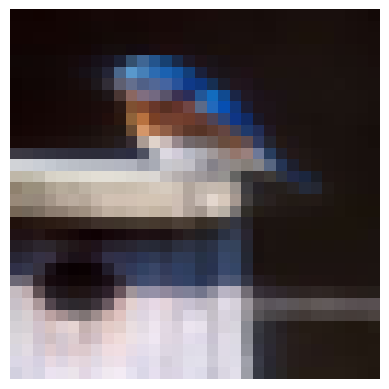

In [136]:
show_torch_image(X[13])

In [137]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),    # 16x16x4
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),    # 8x8x8
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),    # 4x4x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),    # 2x2x16
            nn.ReLU(),
        )
        self.decoder_part_1 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),    # 4x4x16
            nn.ReLU(),
        )
        self.decoder_part_2 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),    # 8x8x8
            nn.ReLU(),
        )
        self.decoder_part_3 = nn.Sequential(
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),    # 16x16x4
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # 32x32x3
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder_part_1(encoded)
        # print(f"decoder_1 output shape: {decoded.shape}")
        decoded = self.decoder_part_2(decoded)
        # print(f"decoder_2 output shape: {decoded.shape}")
        decoded = self.decoder_part_3(decoded)
        # print(f"decoder_3 output shape: {decoded.shape}")
        return decoded

In [152]:
def validate(model, loss_func, valid_dl):
    model.eval()
    with torch.no_grad():
        tot_loss = 0.
        count = 0
        for xb, _ in valid_dl:
            pred = model(xb)
            loss = loss_func(255 * pred, xb)
            tot_loss += loss.item()
            count += len(xb)
    return tot_loss / count

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(255 * pred, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        tot_loss_count = validate(model, loss_func, valid_dl)
        print(f"Validation loss: {tot_loss_count}")

In [139]:
class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [140]:
train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

In [141]:
print(len(train_ds))

8000


In [142]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [153]:
model = ConvolutionalAutoencoder()
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [154]:
fit(10, model, loss_func, opt, train_dl, valid_dl)

Epoch 1/10
Validation loss: 72.02756274414062
Epoch 2/10
Validation loss: 47.10017645263672
Epoch 3/10
Validation loss: 40.25708822631836
Epoch 4/10
Validation loss: 34.31646401977539
Epoch 5/10
Validation loss: 31.783848571777344
Epoch 6/10
Validation loss: 29.682344604492187
Epoch 7/10
Validation loss: 28.77660647583008
Epoch 8/10
Validation loss: 28.146220916748046
Epoch 9/10
Validation loss: 27.20933923339844
Epoch 10/10
Validation loss: 26.988009216308594


torch.Size([1, 3, 32, 32])


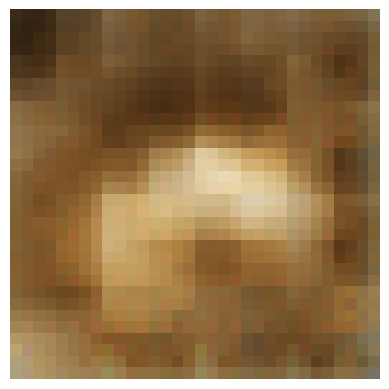

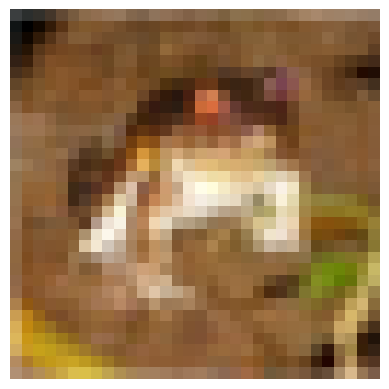

In [156]:
sample_output = model(x_train[0].unsqueeze(0))
print(sample_output.shape)
show_torch_image(255*sample_output.squeeze(0).detach())
show_torch_image(x_train[0])

In [151]:
sample_output

tensor([[[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00]],

         [[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000